###Setting up our Random Number Generator

In [1]:
%%writefile random_number_gen.pyx

import numpy as np
cimport numpy as np

from cpython.mem cimport PyMem_Malloc, PyMem_Free
cdef class RandomNumberGen:
    cdef unsigned long long mod1, a1, a2, a3, mod2, b1, b2, b3, x0, x1, x2
    cdef double multiplicator
    cdef bint LHS

    def __cinit__(self):
        self.mod1 = 2**31 - 1
        self.a1 = 0
        self.a2 = 63308
        self.a3 = -183326
        self.mod2 = 2145483479
        self.b1 = 86098
        self.b2 = 0
        self.b3 = -539608
        self.x0=17  ## Define Seed Here
        self.x1=37  ## Define Seed Here
        self.x2=13337 ## Define Seed Here
        self.multiplicator=4.656612875245797e-10
        self.LHS=True

    cpdef double Scrambled_Random(self):
        cdef unsigned long long Component1, Component2, Combined, y
        Component1 = (self.x2 * self.a1 + self.x1 * self.a2 + self.x0 * self.a3) % self.mod1
        Component2 = (self.x2 * self.b1 + self.x1 * self.b2 + self.x0 * self.b3) % self.mod2
        Combined = (Component1 - Component2) % self.mod1
        if Combined < 0:
            Combined += self.mod1
        y = Combined
        y ^= (y << 17)  # Parentheses to avoid type mismatch
        y ^= (y >> 15)  # Parentheses to avoid type mismatch
        y ^= (y << 26)  # Parentheses to avoid type mismatch
        y = y % self.mod1
        self.x2, self.x1, self.x0 = y, self.x2, self.x1

        return y*self.multiplicator

    cpdef np.ndarray generate_matrix(self, int rows,int cols):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t i, j

        for i in range(rows):
            for j in range(cols):
                matrix[i, j] = self.Scrambled_Random()




        return matrix
    cpdef np.ndarray inverse_transform(self, np.ndarray input_matrix,np.ndarray CDF_matrix,np.ndarray X_vector):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((input_matrix.shape[0], input_matrix.shape[1]), dtype=np.double)
        cdef Py_ssize_t i, j
        cdef double u
        for i in range(input_matrix.shape[0]):
            for j in range(input_matrix.shape[1]):
                u = input_matrix[i, j]
                matrix[i, j] = np.interp(u, CDF_matrix, X_vector)

        return matrix
    cpdef np.ndarray generate_poisson(self,int rows,int cols,double lambda_,bint Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        cdef Py_ssize_t  i, j
        cdef double comp=np.exp(-lambda_)

        cdef double u,u2,k1,k2,comp2,Prob
        if Antithetic:
            for i in range(rows//2):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=self.Scrambled_Random()
                    u2=1-u
                    k1=0
                    k2=0
                    
                    while u>comp2:
                        k1=k1+1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    comp2=comp
                    Prob=comp
                    while u2>comp2:  
                        
                        k2=k2+1
                        Prob=lambda_/k2*Prob
                        comp2=comp2+Prob
                    matrix[int(2*i),j]=k1
                    matrix[int(2*i+1),j]=k2

        else:
            for i in range(rows):
                for j in range(cols):
                    comp2=comp
                    Prob=comp
                    u=self.Scrambled_Random()
                    k1=0
                    while u>comp2:
                        k1+=1
                        Prob=lambda_/k1*Prob
                        comp2=comp2+Prob
                    matrix[i,j]=k1
        return matrix
    cpdef np.ndarray generate_normal(self,int rows, int cols,double loc=0,double scale=0,Antithetic=True):
        cdef np.ndarray[np.double_t, ndim=2] matrix = np.zeros((rows, cols), dtype=np.double)
        matrix=np.random.normal.ppf(matrix)
        matrix=loc*np.ones((rows,cols))+scale*matrix
        return matrix


    cpdef np.ndarray generate_double_exponential(self,int rows, int cols,double p, double eta1,double eta2,Antithetic=True):
        cdef double q=1-p
        cdef np.ndarray U,negU,PosSamp,NegSamp,AntPosSamp,AntNegSamp,Ou1,Out2
        if Antithetic:
            U=self.generate_matrix(rows//2,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-U))
            Out1=np.where(U<p*np.ones((rows//2,cols)),PosSamp,NegSamp)
            negU=np.ones((rows//2,cols))-U
            AntPosSamp=(1/eta2)*np.log((1/q)*negU)
            AntNegSamp=(1/eta1)*np.log((1/p)*(np.ones((rows//2,cols))-negU))
            Out2=np.where(negU<p*np.ones((rows//2,cols)),AntPosSamp,AntNegSamp)
            return np.concatenate([Out1,Out2])
        else:
            U=self.generate_matrix(rows,cols)
            PosSamp=(1/eta2)*np.log((1/q)*U)
            NegSamp=-(1/eta1)*np.log((1/p)*(np.ones((rows,cols))-U))
            Out1=np.where(U<p*np.ones((rows,cols)),PosSamp,NegSamp)
            return Out1


Overwriting random_number_gen.pyx


In [2]:
!cython --cplus random_number_gen.pyx

C:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [3]:
%%writefile setup.py
from setuptools import setup
from Cython.Build import cythonize
import numpy

setup(
    ext_modules=cythonize("random_number_gen.pyx"),
    include_dirs=[numpy.get_include()]
)

Overwriting setup.py


In [4]:
!python setup.py build_ext --inplace

Compiling random_number_gen.pyx because it changed.
[1/1] Cythonizing random_number_gen.pyx
running build_ext
building 'random_number_gen' extension
"C:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\bin\HostX86\x64\cl.exe" /c /nologo /O2 /W3 /GL /DNDEBUG /MD -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\include -Ic:\Users\Bram\AppData\Local\Programs\Python\Python312\Include "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Tools\MSVC\14.39.33519\ATLMFC\include" "-IC:\Program Files\Microsoft Visual Studio\2022\Community\VC\Auxiliary\VS\include" "-IC:\Program Files (x86)\Windows Kits\10\include\10.0.22621.0\ucrt" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\um" "-IC:\Program Files (x86)\Windows Kits\10\\include\10.0.22621.0\\share

c:\Users\Bram\AppData\Local\Programs\Python\Python312\Lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: c:\Users\Bram\JumpDiffusionModel\random_number_gen.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


###Comparing RNGs

In [5]:
class RandomNumberGen():
    def __init__(self,seed):
        self.mod1=2**31-1
        self.a1=0
        self.a2=63308
        self.a3=-183326
        self.mod2=2145483479
        self.b1=86098
        self.b2=0
        self.b3=-539608
        self.x0,self.x1,self.x2=seed


    def Scrambled_Random(self):
        Component1=(self.x2*self.a1+self.x1*self.a2+self.x0*self.a3)%self.mod1
        Component2=(self.x2*self.b1+self.x1*self.b2+self.x0*self.a3)%self.mod2
        Combined=(Component1-Component2)%self.mod1 ##mod1>mod2
        if Combined<0:
            Combined+=self.mod1
        y=Combined
        y^=y<<17


        y^=y>>15


        y^=y<<26

        y=y%self.mod1

        self.x2,self.x1,self.x0=y,self.x2,self.x1

        return y/self.mod1
    def Random(self):
        Component1=(self.x2*self.a1+self.x1*self.a2+self.x0*self.a3)%self.mod1
        Component2=(self.x2*self.b1+self.x1*self.b2+self.x0*self.a3)%self.mod2
        Combined=(Component1-Component2)%self.mod1 ##mod1>mod2
        if Combined<0:
            Combined+=self.mod1
        self.x2,self.x1,self.x0=Combined,self.x2,self.x1
        return Combined/self.mod1
    def LCG(self):
        new=(self.x2*self.a2)%self.mod1
        self.x2=new
        new=new/self.mod1
        return new


In [6]:
import time
import numpy as np
import random_number_gen
RNG2=random_number_gen.RandomNumberGen()
RNG=RandomNumberGen((14,17,27))
start=time.time()
X=np.random.rand(1_000_000)
end=time.time()
print("time taken:",end-start)
start=time.time()
X=[RNG.Scrambled_Random() for _ in range(1_000_000)]
end=time.time()

print("time taken:",end-start)
start=time.time()
X=RNG2.generate_matrix(1_000_000,1)
end=time.time()
print("time taken:",end-start)

time taken: 0.004969120025634766
time taken: 1.5661332607269287
time taken: 0.0473332405090332


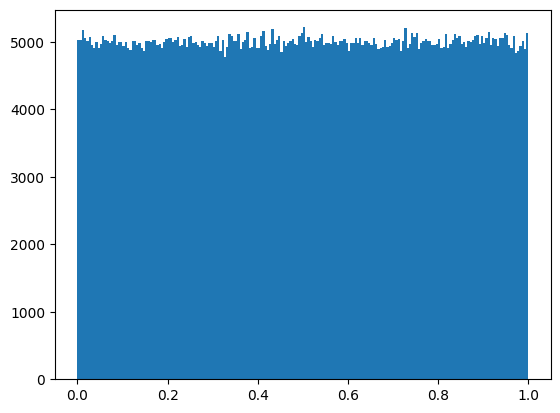

In [7]:
import matplotlib.pyplot as plt
plt.hist(X,bins=200
         )
plt.show()


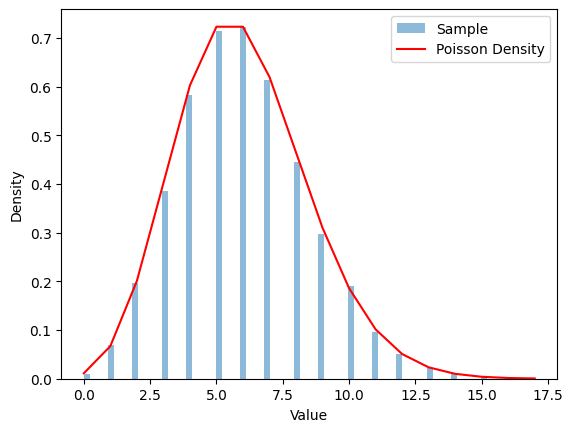

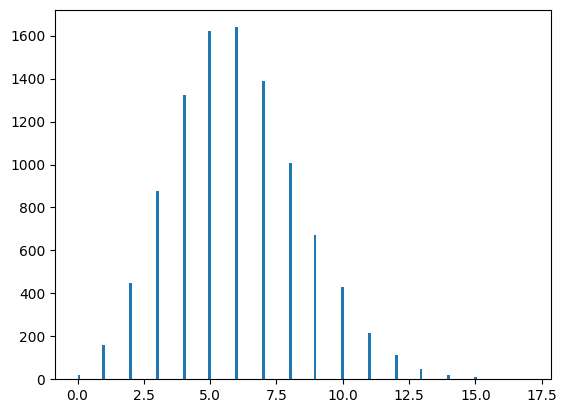

In [8]:
import random_number_gen
gen=random_number_gen.RandomNumberGen()
import numpy as np
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
m=6
sample=gen.generate_normal()
import matplotlib.pyplot as plt
value,bins,_=plt.hist(sample, bins=75, density=True, alpha=0.5, label='Sample')
x = np.arange(0, np.max(sample) + 1)
pmf = poisson.pmf(x, mu=m)
plt.plot(x, pmf*max(value)/max(pmf), 'r-', label='Poisson Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.hist(sample,bins=200)
plt.show()


###CGMY Characteristic function inversion

Fourier Inversion Parameters:###########
alpha: 1.5060105705854605
D: 62.63946549765031
L_opt: 24.0
h: 0.04540252987314952
N: 529.0
eta: 0.11841108789725957


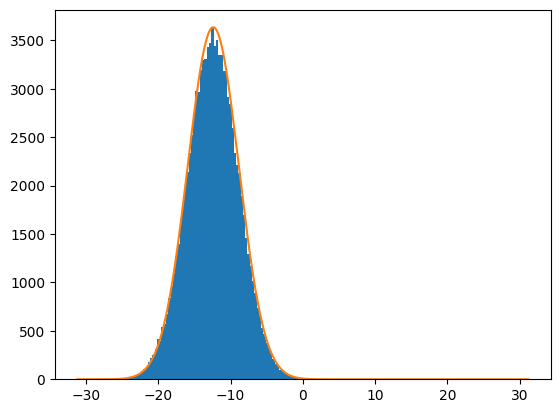

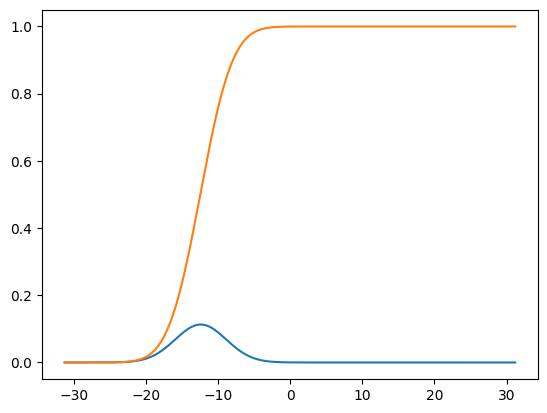

In [9]:

from scipy.special import gamma,gammaincc
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import scipy
import random_number_gen
  # Rest of the code...
class CGMY():
  def __init__(self, C, G, M, Y, t, error):
    self.C = C
    self.G = G
    self.M = M
    if Y == int(Y):
      self.Y = Y - 0.03  ##to avoid overflow during gamma function evaluation
    else:
      self.Y = Y
    self.t = t
    self.error = error

  def characteristic_function(self,u,t,increment=[0,0,0,0]):

      C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
      return np.exp(t*C*gamma(-Y)*((M-1j*u)**Y-M**Y+(G+1j*u)**Y-G**Y))

  def calculate_K(self,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    
    return -C*gamma(-Y)*(M**Y+G**Y)

  def reg_characteristic_function(self,u,t):
    if u!=0:
      return -(1-np.cos(u*self.D))/(1j*u)*self.characteristic_function(u,t)
    else:
      return 0

  def L_error(self,L,B,b,beta,D,error):

    Bounderror=D*B/(np.pi*beta*b**(1/beta))*gammaincc(1/beta,b*(L/2)**beta)-error

    return L if Bounderror<0 else np.inf ##if bound is met, return L. Else, return infinity for penalty
  def alpha_minimization(self, alpha):
    t, error = self.t, self.error
    return np.real((2 / alpha) * np.log(
      (self.characteristic_function(1j * alpha, t) + self.characteristic_function(-1j * alpha, t)) / (2 * error / 3)))
  def L_value(self,b):
    res=optimize.minimize_scalar(self.L_error,args=(self.B,b,self.beta,self.D,self.error),bracket=[0, 1000], method='bounded',bounds=(0,35))
    return res.x
  def calculate_zeta(self, alpha):
    C, G, M, Y = self.C, self.G, self.M, self.Y
    term1 = -self.t * C * gamma(-Y) * (G ** Y - (G - alpha) ** Y)
    term2 = -self.t * C * gamma(-Y) * (M ** Y - (M + alpha) ** Y)
    term1 = np.clip(term1, a_min=None, a_max=600)#for numerical stability
    term2 = np.clip(term2, a_min=None, a_max=600)#for numerical stability
    return np.exp(np.logaddexp(term1, term2))

  def calculate_h_from_C(self, C):
    X = self.error * 2 * np.pi / (3 * C)
    return -2 * np.pi * self.alpha / (np.log(X / (1 + X)))
  def calculate_f(self,u,increment=[0,0,0,0]):
    C,G,M,Y=np.add([self.C,self.G,self.M,self.Y],increment)
    part1=(G**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/G))
    part2=(M**2/u**2+1)**(Y/2)*np.cos(Y*np.arctan(u/M))
    return gamma(-Y)*(part1+part2)
  def abs_char(self,u,alpha):
    return np.exp(self.t*self.K+self.t*self.C*np.abs(u)**self.Y*self.calculate_f(u,[0,-alpha,alpha,0]))


  def calculate_bound_A_integrals(self, alpha, u_star):
    """
    Calculates the bound A integrals for a given alpha and u_star.

    Parameters:
    alpha (float): The alpha value.
    u_star (float): The u_star value.

    Returns:
    float: The calculated bound A value.
    """
    stand_incr = [0, -alpha, alpha, 0]
    ##for calculating positive alpha integrals and zeta
    pos_alpha_K = self.calculate_K(increment=stand_incr)

    pos_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,alpha),10e-10,u_star)[0]

    pos_alpha_upp = np.exp(self.t * pos_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                self.b * u_star ** self.beta)
    
    pos_alpha_all_int = self.calculate_zeta(alpha) * (pos_alpha_int + pos_alpha_upp)
    ##for calculating negative alpha integrals and zeta
    neg_incr = [0, alpha, -alpha, 0]
    
    neg_alpha_K = self.calculate_K(increment=neg_incr)

    neg_alpha_int = scipy.integrate.quad(lambda x: self.abs_char(x,-alpha),10e-10,u_star)[0]
    
    neg_alpha_upp = np.exp(self.t * neg_alpha_K) / (self.beta * self.b ** (1 / self.beta)) * gammaincc(1 / self.beta,
                   self.b * u_star ** self.beta)

    neg_alpha_all_int = self.calculate_zeta(-alpha) * (neg_alpha_int + neg_alpha_upp)

    
    all_int = pos_alpha_all_int + neg_alpha_all_int+10e-9 #for numerical stability

    #for numerical stability
    part1 = np.exp(np.clip(((-self.D * self.alpha / 2+2*(self.D * self.alpha))), a_min=None, a_max=600))

    part2 = 2 * np.exp(np.clip((-self.D * self.alpha / 2+ self.D * self.alpha), a_min=None, a_max=600))
    part3 = np.exp(-self.D * self.alpha / 2)
    
    A = 1 / self.alpha * (part1+part2+part3) + all_int
    return A 

  def generate_cdf(self):
    """
    Generate the cumulative distribution function (CDF) for the Jump Diffusion Model.

    Parameters:
    

    Returns:
    - x_range (numpy.ndarray): An array of x values.
    - M (numpy.ndarray): An array of real values representing the CDF.

    """
    t=self.t
    ##Regularization error
    alpha_bounds = (0, np.min([self.G, self.M]))
    optimization = optimize.minimize_scalar(self.alpha_minimization, 1, bounds=alpha_bounds)
    self.alpha = optimization.x
    print("Fourier Inversion Parameters:###########")
    print("alpha:", self.alpha)
    self.D = optimization.fun
    print("D:", self.D)
    ##Truncating error
    self.K = self.calculate_K()
    K=self.K
    self.beta = self.Y
    self.B = np.exp(t * K)

    if self.Y > 1:
      u_star = max(self.G, self.M) * max(np.tan(np.pi / (2 * self.Y)), -1 / np.tan(self.Y * np.pi / 2))

      self.b = -t * self.C * self.calculate_f(np.ceil(u_star))
      C = self.calculate_bound_A_integrals(self.alpha, u_star)

      h=self.calculate_h_from_C(C)
      L_opt = max(self.L_value(self.b), np.ceil(u_star))
     
    elif self.Y > 0:
      b = -t * 2 * self.C * gamma(-self.Y) * np.cos(np.pi * self.Y / 2)
      L_opt = self.L_value(b)
      A = (2 * np.exp(-self.D * self.alpha / 2) * (np.exp(self.D * self.alpha) + 1) ** 2 * self.B * gamma(
        1 / self.beta)) / (self.alpha * self.beta * b ** (1 / self.beta))

      h=self.calculate_h_from_C(A)
    print("L_opt:", L_opt)
    print("h:", h)

    N = np.ceil(L_opt / h)
    print("N:", N)
    eta = self.D / N
    print(  "eta:", eta)





    ###Vectorized Operations for faster computation
 
    u_domain = np.arange(-N/2*h, (N/2)*h, h)
    x_range = np.arange(-N/2*eta, (N/2)*eta, eta)

    const = 1/(2*np.pi) * h

    
    reg_char_func_vect = np.vectorize(lambda u: self.reg_characteristic_function(u, t))

    # Computing the characteristic values for each u in u_domain
    characteristic_values = reg_char_func_vect(u_domain)

    # Pre-compute the exponential part using broadcasting
    # np.outer effectively creates a matrix where each row corresponds to an element in u_domain and each column to an element in x_range
    exp_matrix = np.exp(-1j * np.outer(u_domain, x_range))

    # Element-wise multiplication of exp_matrix with characteristic_values (reshaped for broadcasting)
    vect = exp_matrix * characteristic_values[:, np.newaxis]

    # Compute results by integrating (summing) over the u_domain for each x_range index
    res = const * vect
    real_res = np.sum(res, axis=0)  # Summing along the 'u_domain' axis

    M2 = real_res  # M contains the real parts of the computed values for each x_range index
    
    M2+=np.ones(len(M2))*0.5
    
    return x_range,np.real(M2)

# Test the code
cgmy = CGMY(C=24 , G=10, M=12, Y=1.7, t=65/365, error=10e-7)

C=cgmy.generate_cdf()
sample_gen=random_number_gen.RandomNumberGen()
sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0])
hist_values,bins,_=plt.hist(sample_gen.inverse_transform(sample_gen.generate_matrix(100000,1),C[1],C[0]),bins=100)
Dx=C[0][1]-C[0][0]
D=np.diff(C[1])/Dx

plt.plot(C[0][1:],D*max(hist_values)/max(D))
plt.show()

plt.plot(C[0][1:],D)
plt.plot(C[0],C[1])

plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random_number_gen
gen=random_number_gen.RandomNumberGen()
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price of a European call option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def monte_carlo_call(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * norm.ppf(np.array(gen.generate_matrix(paths,1)) ) )
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    return call_price_mc
def monte_carlo_call_antithetic(S, K, T, r, sigma, paths):
    """Monte Carlo simulation for the European call option price."""
    dt = T
    # Simulating the end stock price
    sample=norm.ppf(np.array(gen.generate_matrix(paths//2,1)) )
    #np.random.standard_normal(paths//2)
    sample=np.concatenate([sample,-sample])
    ST = S * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sample)
    # Calculating the payoff
    payoffs = np.maximum(ST - K, 0)
    # Discounting the payoff back to present value
    call_price_mc = np.exp(-r * T) * np.mean(payoffs)
    return call_price_mc

def plot_convergence(S, K, T, r, sigma, max_paths, step):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = range(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    # plt.plot(paths_range, diff, label='MC Estimate')

    # plt.grid(True)

def plot_convergence_antithetic(S, K, T, r, sigma, max_paths, step):
    """Plot the convergence of the Monte Carlo simulation to the Black-Scholes price."""
    bs_price = black_scholes_call(S, K, T, r, sigma)
    paths_range = range(step, max_paths + step, step)
    mc_prices = []

    for num_paths in paths_range:
        mc_price = monte_carlo_call_antithetic(S, K, T, r, sigma, num_paths)
        mc_prices.append(mc_price)

    diff=np.abs(mc_prices-bs_price*np.ones(len(mc_prices)))
    # plt.plot(paths_range, diff, label='MC Estimate Antithetic')

    # plt.xlabel('Number of Paths')
    # plt.ylabel('absolute difference')
    # plt.title('Convergence of Monte Carlo Estimates to Black-Scholes Price Antithetic')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

# Example parameters
S = 100  # Stock price
K = 100  # Strike price
T = 1    # Time to expiration in years
r = 0.05 # Risk-free rate
sigma = 0.2  # Volatility

# Uncomment below line to execute the plotting function
%timeit plot_convergence(S, K, T, r, sigma, 100000, 100)
%timeit plot_convergence_antithetic(S, K, T, r, sigma, 100000, 100)
